<a href="https://colab.research.google.com/github/MarkovMarkowitz/MarkovMarkowitz/blob/main/Day_Trading_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**DAY TRADING STRATEGY**

# Notebook Instructions

1. If you are new to Jupyter notebooks, please go through this introductory manual <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank">here</a>.
1. Any changes made in this notebook would be lost after you close the browser window. **You can download the notebook to save your work on your PC.**
1. Before running this notebook on your local PC:<br>
i.  You need to set up a Python environment and the relevant packages on your local PC. To do so, go through the section on "**Run Codes Locally on Your Machine**" in the course.<br>
ii. You need to **download the zip file available in the last unit** of this course. The zip file contains the data files and/or python modules that might be required to run this notebook.

In [91]:
# For data manupulations

START = '2019-01-01'
END = '2023-08-01'

import pandas as pd
import numpy as np
import yfinance as yf

# For plotting
import matplotlib.pyplot as plt

# Read data from CSV file
#data = pd.read_csv('../data/AMZN_2018_2019.csv', index_col ='Date')
data = yf.download("CANTE.IS",START, END)

data_close = data['Adj Close']
# Convert index into datetime format
data.index = pd.to_datetime(data.index,format="%d-%m-%Y")

# Calculate adjustment factor
adjusted_factor = data['Adj Close'] / data['Close']

# Calculate adjusted open price
data['Adj Open'] = adjusted_factor * data['Open']

data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Adj Open
Date,,,,,,,
2021-04-30,1.716,1.716,1.716,1.716,1.716,4717417,1.716
2021-05-03,1.884,1.884,1.884,1.884,1.884,2911935,1.884
2021-05-04,2.072,2.072,2.072,2.072,2.072,9266047,2.072
2021-05-05,1.944,1.992,1.868,1.868,1.868,128557952,1.944
2021-05-06,1.796,1.900,1.700,1.760,1.760,238104665,1.796


In [92]:
# Calculate returns
data['returns'] = (data['Adj Open'] - data['Adj Close'].shift(1)) / data['Adj Close'].shift(1)

In [93]:
# Calculate standard deviation of returns
data['std'] = data['returns'].rolling(45).std()

In [94]:
data['positions'] = np.nan

longs_entry = data['returns'] <  0.30 * data['std']
short_entry = data['returns'] > 0.30 * data['std']

data.loc[longs_entry, 'positions'] = 1
data.loc[short_entry, 'positions'] = -1

data = data.dropna()

In [95]:
data['strategy_returns'] = ((data['Adj Close'] - data['Adj Open']) / data['Adj Open']) * data.positions

<ipython-input-95-bf47a1e8289a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['strategy_returns'] = ((data['Adj Close'] - data['Adj Open']) / data['Adj Open']) * data.positions


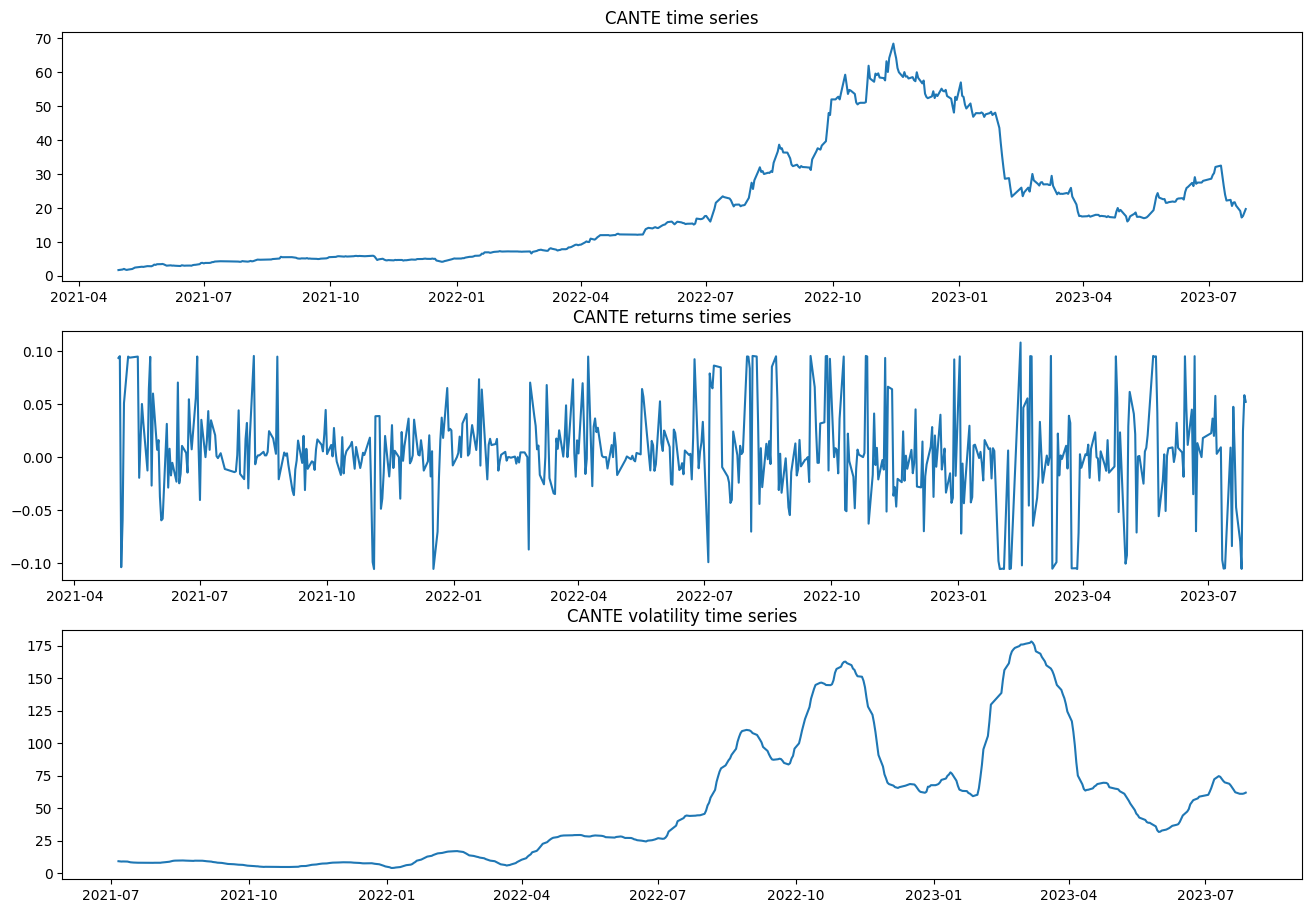

In [96]:
plt.subplot(3, 1, 1)
plt.plot(data_close)
plt.title("CANTE time series")

data_log_returns = data_close.pct_change().apply(lambda x: np.log(1+x))

plt.subplot(3, 1, 2)
plt.plot(data_log_returns)
plt.title("CANTE returns time series")

plt.subplot(3, 1, 3)
data_vlt = data_close.rolling(45).std()*(252**0.5)
plt.title("CANTE volatility time series")
plt.plot(data_vlt)

fig = plt.gcf()
fig.set_size_inches(16, 11)
plt.show()

<ipython-input-97-6f5ecaf1fa9c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cumulative_strategy_returns'] = (data.strategy_returns+1).cumprod()


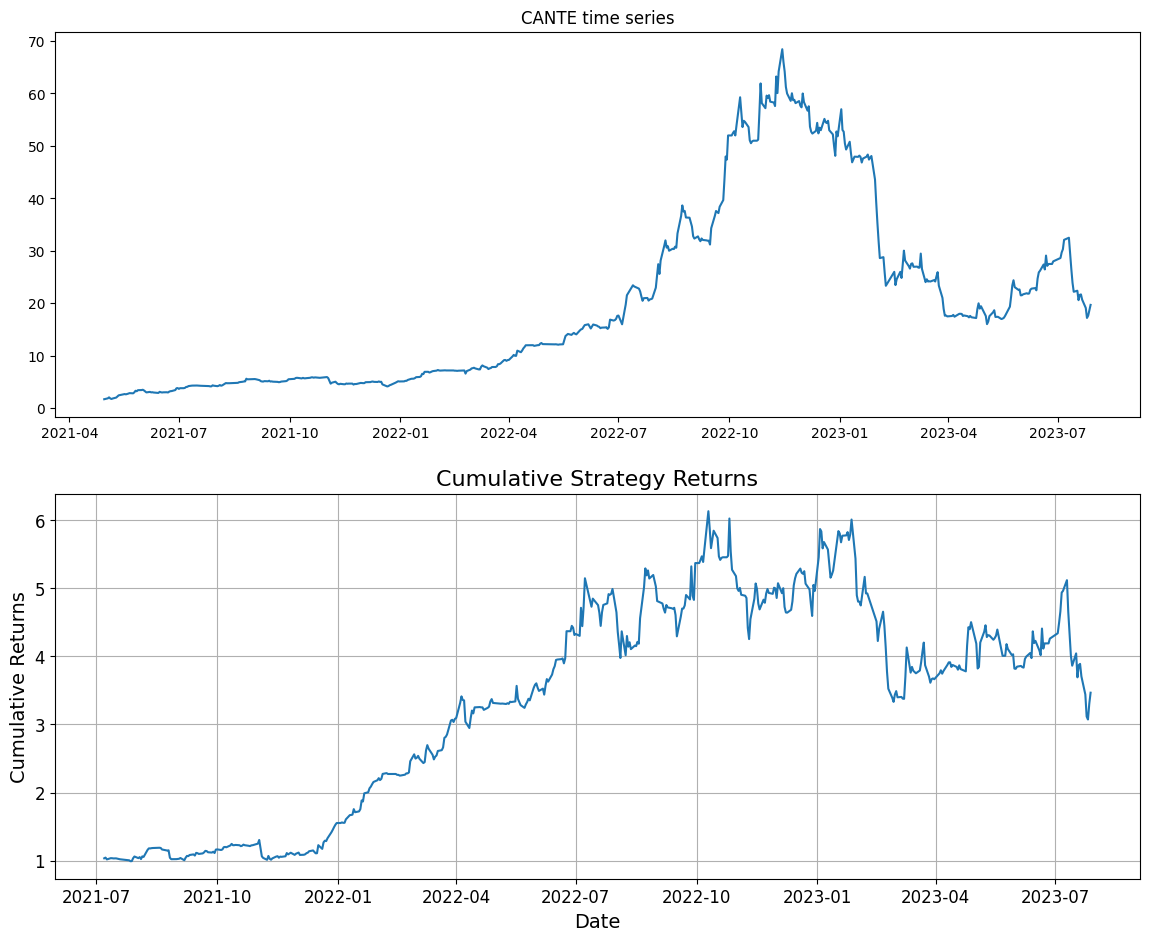

In [97]:
# Plot cumulative returns
plt.figure(figsize=(14,11))

plt.subplot(2, 1, 1)
plt.plot(data_close)
plt.title("CANTE time series")

data['cumulative_strategy_returns'] = (data.strategy_returns+1).cumprod()
plt.subplot(2, 1, 2)
plt.plot(data.cumulative_strategy_returns)
plt.title("CANTE returns time series")


# Cumulative strategy returns




plt.grid()

# Define the label for the title of the figure
plt.title('Cumulative Strategy Returns', fontsize=16)

# Define the labels for x-axis and y-axis
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Returns', fontsize=14)

# Define the tick size for x-axis and y-axis
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()